# Detecting sarcasm in news headlines

## Section 1: Introduction
### Project overview
Objective of this project is to build a sarcasm detector which detects whether a news headline is sarcastic or not? We have supervised data of 20k+ news headlines with a flag whether the news contains sarcasm. We are aiming to build a binary classification model and later test it on a subset of data. Application of this model can be to filter out sarcastic news headlines from serious ones and help news curating organisations and pages in shortlisting relevant news articles.

We will be using the following dataset uploaded on Kaggle - <a href="https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection?resource=download">Link</a>
### Metrics
Since, the use case doesn't require a higher need for only precision or only recall, we can use F1 score or simple accuracy (since data is balanced) as the main metric to consider for tuning. 

## Section 2: Load and Clean Dataset
### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import pickle
import shap
shap.initjs()
import wordcloud
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hk25439\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hk25439\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Setting up the directory

In [2]:
data_path = "Data\\"
output_path = "Output\\"
model_path = "Models\\"

### Importing data
The data contains 2 files, with same schema

In [3]:
df_v1 = pd.read_json(data_path + "Sarcasm_Headlines_Dataset.json", lines=True)
print(df_v1.shape)
df_v1.head()

(26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
df_v2 = pd.read_json(data_path + "Sarcasm_Headlines_Dataset_v2.json", lines=True)
print(df_v2.shape)
df_v2.head()

(28619, 3)


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [5]:
## Checking if both datasets contain different records or same
len(set(df_v1["headline"]).intersection(set(df_v2["headline"])))
## v2 file looks like a superset but v1 file still has records which are not present in v2

26602

In [6]:
## Concating both files
df_f = pd.concat([df_v1, df_v2])
print(df_f.shape)

(55328, 3)


### Data cleaning

In [7]:
## Dropping irrelevant columns
df_f.drop("article_link", axis=1, inplace=True)
print(df_f.shape)

(55328, 2)


In [8]:
## Dropping duplicate records
df_f.drop_duplicates(inplace=True)
print(df_f.shape)

(28503, 2)


## Section 3: Exploratory Data Analysis

In [9]:
## Resetting index so that we can have a unique identifier column
df_f = df_f.reset_index()
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28503 entries, 0 to 28502
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         28503 non-null  int64 
 1   headline      28503 non-null  object
 2   is_sarcastic  28503 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 668.2+ KB


No column contains any null value

In [10]:
df_f.describe()

,index,is_sarcastic
count,28503.000000,28503.000000
mean,13400.282216,0.475459
std,7746.287526,0.499406
min,0.000000,0.000000
25%,6690.500000,0.000000
50%,13403.000000,0.000000
75%,20096.500000,1.000000
max,28589.000000,1.000000


Ratio of class 1 : class 0 is 47:53 which makes the dataset balanced across both classes. Let's visualize

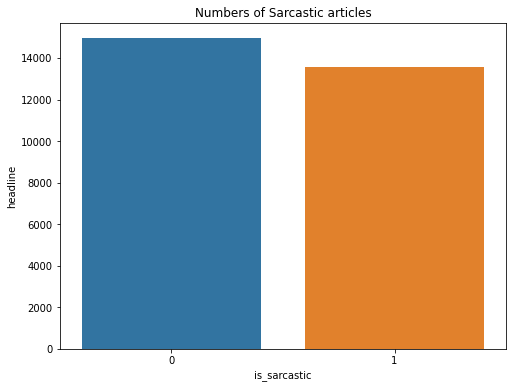

In [11]:
df_f_grpby = pd.DataFrame(df_f.groupby('is_sarcastic')['headline'].count()).reset_index()
plt.figure(figsize=[8,6])
ax = sns.barplot(data=df_f_grpby, x='is_sarcastic', y='headline')
plt.title("Numbers of Sarcastic articles");

In [12]:
## Checking is there are still duplicates in headline column
df_f["headline"].value_counts()

former versace store clerk sues over secret 'black code' for minority shoppers                 1
aol acquires time-warner in largest-ever expenditure of pretend internet money                 1
congress must reclaim war-making authority                                                     1
supreme leader khamenei says iranian nuclear weapons are a u.s. 'myth'                         1
5 ways to enjoy your engagement                                                                1
                                                                                              ..
man's whole job undoing handiwork of self-checkout machine                                     1
these kids' portraits of the trump administration should hang in a gallery                     1
defensive clinton campaign releases new 'who are you to judge me?' ad                          1
world health organization adds gunfire, explosions to list of natural causes of death          1
study: 83% of marathon spectat

### Word counter

In [20]:
def word_counter(df, col, times_in_doc = False):
    '''
    Counts frequency of each word in a column of textual entries

    Input: Dataframe, column with text values

    Output: New dataframe with words as index and "Count" column with count of the word in entire column
    '''
    words_c = {}
    for i, row in df.iterrows():
        words = row[col].split()
        if times_in_doc == True:
            words = set(words)
        for w in words:
            if w in words_c.keys():
                words_c[w] += 1
            else:
                words_c[w] = 1
    wc_df = pd.DataFrame(words_c, index=["Count"]).transpose()
    wc_df = wc_df.sort_values("Count", ascending=False)
    return wc_df

In [21]:
wc_df = word_counter(df_f, "headline")
print(wc_df.shape)
wc_df.head(10)

(38212, 1)


,Count
to,9010
of,6244
the,5254
in,4515
for,3609
a,3060
on,2597
and,1949
with,1945
is,1695


## Section 4: Feature Engineering

In [13]:
## Creating a new column for length of headline
df_f['headline_length'] = df_f['headline'].apply(lambda x : len(x))
df_f['headline_length'].value_counts()

65     700
62     671
64     622
63     610
69     601
      ... 
152      1
237      1
199      1
190      1
135      1
Name: headline_length, Length: 154, dtype: int64

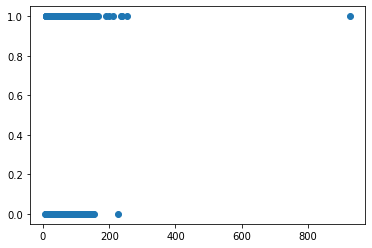

In [14]:
plt.scatter(df_f["headline_length"], df_f["is_sarcastic"])

It looks like sarcastic headlines have higher text length. Also, we have one outlier with more than 500 characters in headline

In [15]:
df_f[df_f['headline_length']>500]

,index,headline,is_sarcastic,headline_length
27090,7302,hot wheels ranked number one toy for rolling d...,1,926


In [16]:
df_f[df_f['headline_length']>500]["headline"].iloc[0]

'hot wheels ranked number one toy for rolling down ramp, knocking over dominoes that send marble down a funnel, dropping onto teeter-totter that yanks on string, causing pulley system to raise wooden block, propelling series of twine rollers that unwind spring, launching tennis ball across room, inching tire down slope until it hits power switch, activating table fan that blows toy ship with nail attached to it across kiddie pool, popping water balloon that fills cup, weighing down lever that forces basketball down track, nudging broomstick on axis to rotate, allowing golf ball to roll into sideways coffee mug, which tumbles down row of hardcover books until handle catches hook attached to lever that causes wooden mallet to slam down on serving spoon, catapulting small ball into cup attached by ribbon to lazy susan, which spins until it pushes d battery down incline plane, tipping over salt shaker to season omelet'

In [17]:
## Removing outliers
print(df_f.shape)
df_f = df_f[df_f['headline_length']<500]
print(df_f.shape)

(28503, 4)
(28502, 4)


### Train-Test split

In [18]:
## Train to test split ratio = 3:1
df_f_train, df_f_test = train_test_split(df_f, train_size=0.75, stratify=df_f["is_sarcastic"])
print(df_f.shape, df_f_train.shape, df_f_test.shape)

(28502, 4) (21376, 4) (7126, 4)


<BarContainer object of 3 artists>

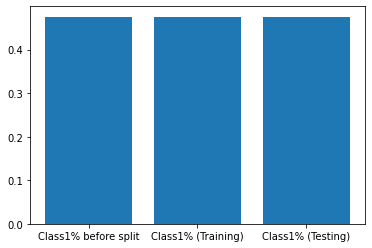

In [19]:
## Checking class1 composition in original dataset, training set and testing set
plt.bar(["Class1% before split", "Class1% (Training)", "Class1% (Testing)"], [df_f["is_sarcastic"].mean(), df_f_train["is_sarcastic"].mean(), df_f_test["is_sarcastic"].mean()])

Class balance is consistent across datasets

### Removing digits and punctuations

In [22]:
## Taking an exmple before removing punctuations and numbers
df_f_train.iloc[2]["headline"].split()

['nypd:',
 'muslim',
 'woman',
 'set',
 'on',
 'fire',
 'just',
 'before',
 '9/11',
 'anniversary']

In [23]:
def text_cleaner(df, col):
    '''
    Removes punctuations and digits from text

    Input: Dataframe, column containing textual values

    Output: Original dataframe with new column with cleaned values
    '''
    c_b = []
    for i, row in df.iterrows():
        s = row[col]
        s = s.replace("\n", "").replace("\t", "").replace(".", " ").replace("  ", " ")
        s = re.sub("\d+", "", s)
        s = re.sub(r'[^\w\s]', '', s)
        s = s.encode("ascii", "ignore").decode()
        s = s.replace("  ", " ")
        s = s.lower().strip()
        c_b.append(s)
    df[col+"_clean"] = c_b
    df[col+"_clean"] = df[col+"_clean"].apply(lambda x : x.split())
    return df

In [24]:
## Checking same example as before after cleaning text
df_f_train2 = text_cleaner(df_f_train, "headline")
df_f_train2.iloc[2]["headline_clean"]

['nypd',
 'muslim',
 'woman',
 'set',
 'on',
 'fire',
 'just',
 'before',
 'anniversary']

In [25]:
## Applying same processing on test set
df_f_test2 = text_cleaner(df_f_test, "headline")
df_f2 = text_cleaner(df_f, "headline")

### Removing stopwords

In [26]:
## Storing nltk package stopwords into a variable
stop_words = set(stopwords.words('english'))

In [27]:
## Taking example before removing stopwords
df_f_train2.iloc[2]["headline_clean"]

['nypd',
 'muslim',
 'woman',
 'set',
 'on',
 'fire',
 'just',
 'before',
 'anniversary']

In [28]:
def remove_words(df, rem_words_l, col):
    '''
    Removes stopwords using nltk package

    Input: Dataframe, list of stopwords, column containing in text

    Output: Dataframe with textual column updated (removed stopwords)
    '''
    c_b = []
    for text in df[col]:
        c_b_v = []
        for w in text:
            if w not in rem_words_l:
                c_b_v.append(w)
        c_b.append(c_b_v)
    df[col] = c_b
    return df

In [29]:
## Taking same example after removing stopwords
df_f_train2 = remove_words(df_f_train2, stop_words, "headline_clean")
df_f_train2.iloc[2]["headline_clean"]

['nypd', 'muslim', 'woman', 'set', 'fire', 'anniversary']

In [30]:
## Applying same processing to test set
df_f_test2 = remove_words(df_f_test2, stop_words, "headline_clean")
df_f2 = remove_words(df_f2, stop_words, "headline_clean")

### Lemmatization

In [31]:
lemmatizer = WordNetLemmatizer()

In [32]:
## Taking example before applying lemmatization
df_f_train2.iloc[2]["headline_clean"]

['nypd', 'muslim', 'woman', 'set', 'fire', 'anniversary']

In [33]:
def nltk_lemmatizer(df, col):
    '''
    Applies lemmatization to each word in column values

    Input: Dataframe, column with text values

    Output: Dataframe with updated column (lemmatized values)
    '''
    c_b = []
    for text in df[col]:
        c_b_v = []
        for w in text:
            if len(w) > 2:
                c_b_v.append(lemmatizer.lemmatize(w))
        c_b.append(c_b_v)
    df[col] = c_b
    return df

In [34]:
## Same example as before after applying lemmatizing (see word "shows" changed to "show")
df_f_train2 = nltk_lemmatizer(df_f_train2, "headline_clean")
df_f_train2.iloc[2]["headline_clean"]

['nypd', 'muslim', 'woman', 'set', 'fire', 'anniversary']

In [35]:
## Applying same preprocessing to test set
df_f_test2 = nltk_lemmatizer(df_f_test2, "headline_clean")
df_f2 = nltk_lemmatizer(df_f2, "headline_clean")

In [36]:
w_l = []
for i in df_f2["headline_clean"]:
    w_l.extend(i)
len(w_l)

201393

### Wordclouds
Wordcloud for the entire dataset

In [37]:
w_l

['former',
 'versace',
 'store',
 'clerk',
 'sue',
 'secret',
 'black',
 'code',
 'minority',
 'shopper',
 'roseanne',
 'revival',
 'catch',
 'thorny',
 'political',
 'mood',
 'better',
 'worse',
 'mom',
 'starting',
 'fear',
 'son',
 'web',
 'series',
 'closest',
 'thing',
 'grandchild',
 'boehner',
 'want',
 'wife',
 'listen',
 'come',
 'alternative',
 'debtreduction',
 'idea',
 'rowling',
 'wish',
 'snape',
 'happy',
 'birthday',
 'magical',
 'way',
 'advancing',
 'world',
 'woman',
 'fascinating',
 'case',
 'eating',
 'labgrown',
 'meat',
 'ceo',
 'send',
 'kid',
 'school',
 'work',
 'company',
 'top',
 'snake',
 'handler',
 'leaf',
 'sinking',
 'huckabee',
 'campaign',
 'friday',
 'morning',
 'email',
 'inside',
 'trump',
 'presser',
 'age',
 'airline',
 'passenger',
 'tackle',
 'man',
 'rush',
 'cockpit',
 'bomb',
 'threat',
 'facebook',
 'reportedly',
 'working',
 'healthcare',
 'feature',
 'apps',
 'north',
 'korea',
 'praise',
 'trump',
 'urge',
 'voter',
 'reject',
 'dull',
 

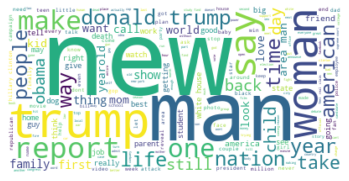

In [38]:
wordcloud = WordCloud(background_color="white").generate(" ".join(w_l))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Wordcloud for Class 1

In [39]:
w_l_c1 = []
for i in df_f2[df_f2['is_sarcastic']==1]["headline_clean"]:
    w_l_c1.extend(i)
len(w_l_c1)

102276

In [40]:
w_l_c1

['mom',
 'starting',
 'fear',
 'son',
 'web',
 'series',
 'closest',
 'thing',
 'grandchild',
 'boehner',
 'want',
 'wife',
 'listen',
 'come',
 'alternative',
 'debtreduction',
 'idea',
 'top',
 'snake',
 'handler',
 'leaf',
 'sinking',
 'huckabee',
 'campaign',
 'nuclear',
 'bomb',
 'detonates',
 'rehearsal',
 'spiderman',
 'musical',
 'cosby',
 'lawyer',
 'asks',
 'accuser',
 'didnt',
 'come',
 'forward',
 'smeared',
 'legal',
 'team',
 'year',
 'ago',
 'stock',
 'analyst',
 'confused',
 'frightened',
 'boar',
 'market',
 'courtroom',
 'sketch',
 'artist',
 'clear',
 'manga',
 'influence',
 'trump',
 'assures',
 'nation',
 'decision',
 'syrian',
 'airstrikes',
 'came',
 'carefully',
 'considering',
 'passing',
 'whim',
 'excon',
 'back',
 'behind',
 'bar',
 'careful',
 'consideration',
 'bush',
 'recommends',
 'oil',
 'drilling',
 'giant',
 'altoid',
 'heading',
 'toward',
 'earth',
 'robin',
 'williams',
 'inflicted',
 'holiday',
 'moviegoer',
 'eighth',
 'straight',
 'year',
 'res

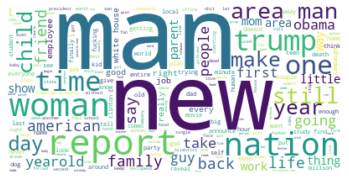

In [41]:
wordcloud = WordCloud(background_color="white").generate(" ".join(w_l_c1))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Wordcloud for Class 0

In [42]:
w_l_c0 = []
for i in df_f2[df_f2['is_sarcastic']==0]["headline_clean"]:
    w_l_c0.extend(i)
len(w_l_c0)

99117

In [43]:
w_l_c0

['former',
 'versace',
 'store',
 'clerk',
 'sue',
 'secret',
 'black',
 'code',
 'minority',
 'shopper',
 'roseanne',
 'revival',
 'catch',
 'thorny',
 'political',
 'mood',
 'better',
 'worse',
 'rowling',
 'wish',
 'snape',
 'happy',
 'birthday',
 'magical',
 'way',
 'advancing',
 'world',
 'woman',
 'fascinating',
 'case',
 'eating',
 'labgrown',
 'meat',
 'ceo',
 'send',
 'kid',
 'school',
 'work',
 'company',
 'friday',
 'morning',
 'email',
 'inside',
 'trump',
 'presser',
 'age',
 'airline',
 'passenger',
 'tackle',
 'man',
 'rush',
 'cockpit',
 'bomb',
 'threat',
 'facebook',
 'reportedly',
 'working',
 'healthcare',
 'feature',
 'apps',
 'north',
 'korea',
 'praise',
 'trump',
 'urge',
 'voter',
 'reject',
 'dull',
 'hillary',
 'actually',
 'cnns',
 'jeffrey',
 'lord',
 'indefensible',
 'barcelona',
 'hold',
 'huge',
 'protest',
 'support',
 'refugee',
 'bloombergs',
 'program',
 'build',
 'better',
 'city',
 'got',
 'bigger',
 'craig',
 'hick',
 'indicted',
 'qatar',
 'depor

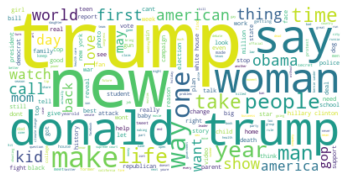

In [44]:
wordcloud = WordCloud(background_color="white").generate(" ".join(w_l_c0))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

There are differences in top words between Class 1 and Class 0

### BagOfWords and Tf-IDF

In [45]:
## Initializing BoW and TF-IDF with uni-gram, bi-gram and tri-gram and max 2k features
countvectorizer = CountVectorizer(analyzer= 'word', stop_words='english', ngram_range=(1,3), max_features = 2000)
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english', ngram_range=(1,3), max_features = 2000)

## Fitting on entire dataset, and transforming on train and test
count_vec = countvectorizer.fit_transform(df_f2["headline_clean"].apply(lambda x : " ".join(x)))
tfidf_vec = tfidfvectorizer.fit_transform(df_f2["headline_clean"].apply(lambda x : " ".join(x)))
count_vec_train = countvectorizer.transform(df_f_train2["headline_clean"].apply(lambda x : " ".join(x)))
tfidf_vec_train = tfidfvectorizer.transform(df_f_train2["headline_clean"].apply(lambda x : " ".join(x)))
count_vec_test = countvectorizer.transform(df_f_test2["headline_clean"].apply(lambda x : " ".join(x)))
tfidf_vec_test = tfidfvectorizer.transform(df_f_test2["headline_clean"].apply(lambda x : " ".join(x)))

count_tokens = countvectorizer.get_feature_names()
tfidf_tokens = tfidfvectorizer.get_feature_names()

count_vec_train = pd.DataFrame(data = count_vec_train.toarray(), index = df_f_train2["index"], columns = count_tokens)
tfidf_vec_train = pd.DataFrame(data = tfidf_vec_train.toarray(), index = df_f_train2["index"], columns = tfidf_tokens)
count_vec_test = pd.DataFrame(data = count_vec_test.toarray(), index = df_f_test2["index"], columns = count_tokens)
tfidf_vec_test = pd.DataFrame(data = tfidf_vec_test.toarray(), index = df_f_test2["index"], columns = tfidf_tokens)

In [46]:
count_vec_train.shape, tfidf_vec_train.shape, count_vec_test.shape, tfidf_vec_test.shape

((21376, 2000), (21376, 2000), (7126, 2000), (7126, 2000))

In [47]:
grams_count = pd.Series(count_vec_train.columns).apply(lambda x : len(x.split())).value_counts()
for i in range(3):
    print("5000 features have " + str(grams_count[i+1]) + " " + str(i+1) + "-grams.")

5000 features have 1903 1-grams.
5000 features have 94 2-grams.
5000 features have 3 3-grams.


In [48]:
## Merging BoW and TF-IDF dfs with original dfs
df_f_train_bow = df_f_train2.merge(count_vec_train, how="left", on="index")
print("Training set - BagOfWords : " + str(df_f_train_bow.shape))
df_f_train_tf = df_f_train2.merge(tfidf_vec_train, how="left", on="index")
print("Training set - TfIDf : " + str(df_f_train_tf.shape))
df_f_test_bow = df_f_test2.merge(count_vec_test, how="left", on="index")
print("Testing set - BagOfWords : " + str(df_f_test_bow.shape))
df_f_test_tf = df_f_test2.merge(tfidf_vec_test, how="left", on="index")
print("Testing set - TfIDf : " + str(df_f_test_tf.shape))

Training set - BagOfWords : (23382, 2005)
Training set - TfIDf : (23382, 2005)
Testing set - BagOfWords : (7382, 2005)
Testing set - TfIDf : (7382, 2005)


In [49]:
## Saving datasets
df_f_train_bow.to_csv(output_path + "df_f_train_bow - 2k.csv")
df_f_test_bow.to_csv(output_path + "df_f_test_bow - 2k.csv")
df_f_train_tf.to_csv(output_path + "df_f_train_tf - 2k.csv")
df_f_test_tf.to_csv(output_path + "df_f_test_tf - 2k.csv")

In [50]:
## Saving vectorizers for future use
pickle.dump(countvectorizer, open(model_path + "count.pickle", "wb"))
pickle.dump(tfidfvectorizer, open(model_path + "tfidf.pickle", "wb"))

## Section 5: Modelling

In [51]:
## Loading finalized training and testing datasets
df_f_train_bow = pd.read_csv(output_path + "df_f_train_bow - 2k.csv", index_col = 0)
df_f_test_bow = pd.read_csv(output_path + "df_f_test_bow - 2k.csv", index_col = 0)
df_f_train_tf = pd.read_csv(output_path + "df_f_train_tf - 2k.csv", index_col = 0)
df_f_test_tf = pd.read_csv(output_path + "df_f_test_tf - 2k.csv", index_col = 0)

In [52]:
print(df_f_train_bow.shape) 
print(df_f_test_bow.shape)
print("-"*50)
print(df_f_train_tf.shape)
print(df_f_test_tf.shape)
print("-"*50)

(23382, 2005)
(7382, 2005)
--------------------------------------------------
(23382, 2005)
(7382, 2005)
--------------------------------------------------


Saving IDs  and Target variable separately

In [53]:
df_f_train_bow_id = df_f_train_bow["index"]
df_f_train_bow_y = df_f_train_bow["is_sarcastic"]
df_f_train_tf_id = df_f_train_tf["index"]
df_f_train_tf_y = df_f_train_tf["is_sarcastic"]

In [54]:
df_f_test_bow_id = df_f_test_bow["index"]
df_f_test_bow_y = df_f_test_bow["is_sarcastic"]
df_f_test_tf_id = df_f_test_tf["index"]
df_f_test_tf_y = df_f_test_tf["is_sarcastic"]

### BoW
Training a model using BoW approach

In [55]:
df_f_train_bow.columns[:40]

Index(['index', 'headline', 'is_sarcastic', 'headline_length',
       'headline_clean', 'able', 'abortion', 'absolutely', 'abuse', 'accept',
       'access', 'accident', 'accidentally', 'according', 'account', 'accused',
       'act', 'acting', 'action', 'activist', 'actor', 'actress', 'actual',
       'actually', 'adam', 'add', 'addiction', 'address', 'administration',
       'admit', 'admits', 'adorable', 'adult', 'advice', 'adviser', 'affair',
       'afghan', 'afghanistan', 'africa', 'african'],
      dtype='object')

In [56]:
drop_cols = ["index", "headline", "is_sarcastic", "headline_clean"]
all_cols = df_f_train_bow.columns.tolist()
s_cols = list(set(all_cols) - set(drop_cols))
len(s_cols)

2001

In [57]:
df_f_train_bow.dtypes.value_counts()

int64     2003
object       2
dtype: int64

In [58]:
df_f_train_bow[s_cols].dtypes.value_counts()

int64    2001
dtype: int64

Final dataset created before modelling contains only numerical values

#### XGBoost
Training a model using XGBoost (Extreme gradient boosting)

In [59]:
## Picking parameters based on best jusgement - We will use hypertuning later
XGC_exp_bow = XGBClassifier(n_estimators=100,
                    max_depth = 6,
                    eta = 0.05)
XGC_exp_bow.fit(df_f_train_bow[s_cols], df_f_train_bow_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [60]:
y_pred_test_exp_bow = XGC_exp_bow.predict(df_f_test_bow[s_cols])

In [61]:
def confusion_mat(actual, predicted, dim, display = True):
    '''
    Returns accuracy, f1 score and confusion metric susing seaborn library

    Input: Actual values, predicted values, # of classes

    Output: Prints accuracy, f1 score and confusion matrix
    '''
    base_cm = confusion_matrix(actual,predicted)
    ct = pd.crosstab(actual,predicted)
    print("Accuracy : ", np.round(accuracy_score(actual,predicted),3))
    score_1 = max(0, 100*f1_score(actual,predicted, average = "weighted"))
    print("F1 Score : ", score_1)
    if display == True:
        group_counts = ["{0:0.0f}".format(value) for value in base_cm.flatten()]
        labels = np.asarray(group_counts).reshape(dim,dim)
        sns.heatmap(ct, annot=labels, fmt='', cmap='Blues')
        plt.show()
    return

Accuracy :  0.679
F1 Score :  66.41774473570459


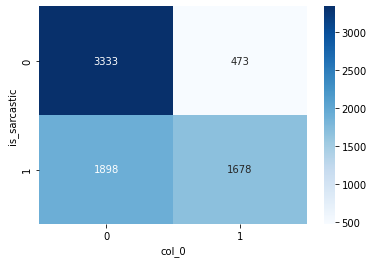

In [62]:
confusion_mat(df_f_test_bow_y, y_pred_test_exp_bow, 2)

In [63]:
y_pred_train_exp_bow = XGC_exp_bow.predict(df_f_train_bow[s_cols])
confusion_mat(df_f_train_bow_y, y_pred_train_exp_bow, 5, display=0)

Accuracy :  0.687
F1 Score :  67.42565415342203


Since the difference between F1 scores of Training and testing is very less - we can conclude that the model is not overfitting

In [64]:
## Checking most important features along with their importances
importances = XGC_exp_bow.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = []
ind = 1
for i in indices[:20]:
    f_name = df_f_train_bow[s_cols].iloc[:,i].name
    top_features.append(f_name)
    print(str(ind) + ". " + str(f_name) + " (" + str(importances[i]) + ")")
    ind += 1

1. man (0.038629156)
2. trump (0.028645955)
3. nation (0.022181138)
4. area (0.02079079)
5. report (0.019026259)
6. local (0.017415894)
7. introduces (0.016675482)
8. study (0.014782527)
9. self (0.013770221)
10. watch (0.0135218855)
11. need (0.0128242895)
12. god (0.012726446)
13. bush (0.012373603)
14. employee (0.0118435)
15. shit (0.0116238855)
16. entire (0.011555426)
17. guy (0.011320586)
18. fucking (0.011292495)
19. friend (0.011178551)
20. protest (0.0105958665)


Average precision-recall score on test: 0.62
Average precision-recall score on train: 0.65


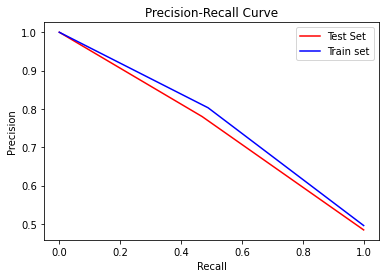

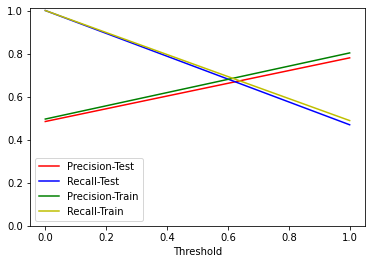

In [65]:
## Plotting Precision-Recall curves
precision, recall, thresholds = precision_recall_curve(df_f_test_bow_y, y_pred_test_exp_bow)
precision_tr, recall_tr, thresholds_tr = precision_recall_curve(df_f_train_bow_y, y_pred_train_exp_bow)
    

average_precision = average_precision_score(df_f_test_bow_y, y_pred_test_exp_bow)
print('Average precision-recall score on test: {0:0.2f}'.format(average_precision))
average_precision_tr = average_precision_score(df_f_train_bow_y, y_pred_train_exp_bow)
print('Average precision-recall score on train: {0:0.2f}'.format(average_precision_tr))
plt.plot(recall, precision, 'r')
plt.plot(recall_tr, precision_tr, 'b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(('Test Set', 'Train set'))
plt.show()

plt.plot(thresholds, precision[:-1], 'r')
plt.xlabel('Threshold')
plt.ylim([0,1.01])

plt.plot(thresholds, recall[:-1], 'b')
plt.xlabel('Threshold')
plt.ylim([0,1.01])
plt.legend(('Precision-Test', 'Recall-Test'))

plt.plot(thresholds_tr, precision_tr[:-1], 'g')
plt.xlabel('Threshold')
plt.ylim([0,1.01])

plt.plot(thresholds_tr, recall_tr[:-1], 'y')
plt.xlabel('Threshold')
plt.ylim([0,1.01])
plt.legend(('Precision-Test', 'Recall-Test', 'Precision-Train', 'Recall-Train'))
plt.show()

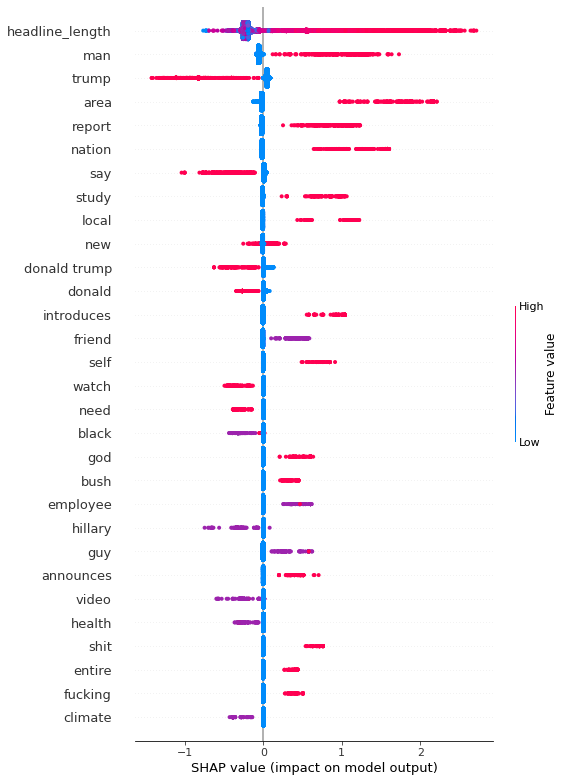

In [66]:
## Plotting SHAP tree explainer plot
explainer = shap.TreeExplainer(XGC_exp_bow)
shap.summary_plot(explainer.shap_values(df_f_train_bow[s_cols]), df_f_train_bow[s_cols], max_display=30, class_names=XGC_exp_bow.classes_)

### Tf-IDf

In [67]:
drop_cols = ["index", "headline", "is_sarcastic", "headline_clean"]
all_cols = df_f_train_tf.columns.tolist()
s_cols = list(set(all_cols) - set(drop_cols))

In [68]:
df_f_train_tf[s_cols].dtypes.value_counts()

float64    2000
int64         1
dtype: int64

In [69]:
len(s_cols)

2001

#### XGBoost

In [70]:
XGC_exp_tf = XGBClassifier(n_estimators=100,
                    max_depth = 6,
                    eta = 0.05)
XGC_exp_tf.fit(df_f_train_tf[s_cols], df_f_train_tf_y )

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, ...)

Accuracy :  0.677
F1 Score :  66.20326720947754


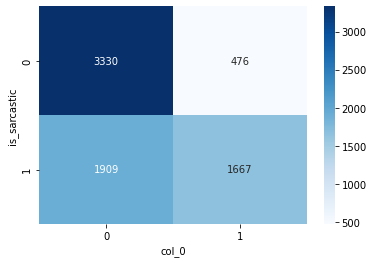

In [71]:
y_pred_test_exp_tf = XGC_exp_tf.predict(df_f_test_tf[s_cols])
confusion_mat(df_f_test_tf_y, y_pred_test_exp_tf, 2)

In [72]:
y_pred_train_exp_tf = XGC_exp_tf.predict(df_f_train_tf[s_cols])
confusion_mat(df_f_train_tf_y, y_pred_train_exp_tf, 5, display=0)

Accuracy :  0.689
F1 Score :  67.5574328446169


F1 score and accuracy across training and testing is consistent - No overfitting

In [73]:
## Checking most important features along with their importances
importances = XGC_exp_tf.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = []
ind = 1
for i in indices[:20]:
    f_name = df_f_train_tf[s_cols].iloc[:,i].name
    top_features.append(f_name)
    print(str(ind) + ". " + str(f_name) + " (" + str(importances[i]) + ")")
    ind += 1

1. man (0.04504971)
2. trump (0.020495366)
3. nation (0.018335415)
4. introduces (0.016421989)
5. area (0.015919764)
6. report (0.015816102)
7. local (0.015157792)
8. headline_length (0.014121677)
9. shit (0.013868869)
10. watch (0.013359128)
11. need (0.01321502)
12. yearold (0.012379005)
13. romney (0.012211813)
14. study (0.012183174)
15. bush (0.011842683)
16. self (0.011835428)
17. excited (0.01147185)
18. archive (0.011364309)
19. asks (0.011182688)
20. new york (0.010951881)


Average precision-recall score on test: 0.62
Average precision-recall score on train: 0.65


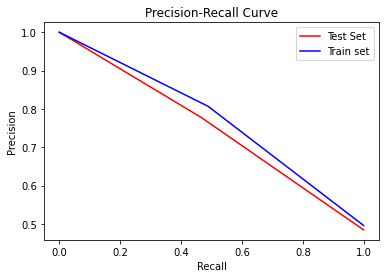

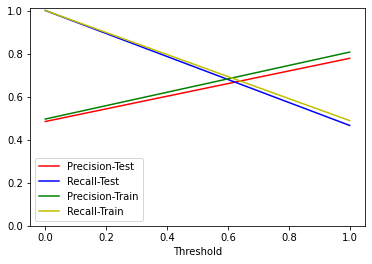

In [75]:
## Plotting Precision-Recall curves
precision, recall, thresholds = precision_recall_curve(df_f_test_tf_y, y_pred_test_exp_tf)
precision_tr, recall_tr, thresholds_tr = precision_recall_curve(df_f_train_tf_y, y_pred_train_exp_tf)
    

average_precision = average_precision_score(df_f_test_tf_y, y_pred_test_exp_tf)
print('Average precision-recall score on test: {0:0.2f}'.format(average_precision))
average_precision_tr = average_precision_score(df_f_train_tf_y, y_pred_train_exp_tf)
print('Average precision-recall score on train: {0:0.2f}'.format(average_precision_tr))
plt.plot(recall, precision, 'r')
plt.plot(recall_tr, precision_tr, 'b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(('Test Set', 'Train set'))
plt.show()

plt.plot(thresholds, precision[:-1], 'r')
plt.xlabel('Threshold')
plt.ylim([0,1.01])

plt.plot(thresholds, recall[:-1], 'b')
plt.xlabel('Threshold')
plt.ylim([0,1.01])
plt.legend(('Precision-Test', 'Recall-Test'))

plt.plot(thresholds_tr, precision_tr[:-1], 'g')
plt.xlabel('Threshold')
plt.ylim([0,1.01])

plt.plot(thresholds_tr, recall_tr[:-1], 'y')
plt.xlabel('Threshold')
plt.ylim([0,1.01])
plt.legend(('Precision-Test', 'Recall-Test', 'Precision-Train', 'Recall-Train'))
plt.show()

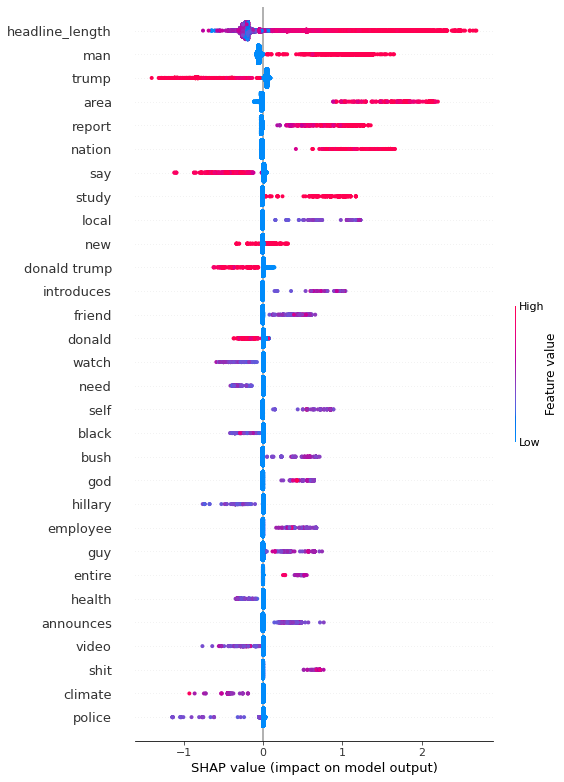

In [76]:
## Plotting SHAP tree explainer plot
explainer = shap.TreeExplainer(XGC_exp_tf)
shap.summary_plot(explainer.shap_values(df_f_train_tf[s_cols]), df_f_train_tf[s_cols], max_display=30, class_names=XGC_exp_tf.classes_)

### Hypertuning
We will apply GridSearchCV on the TF-IDF model (picking one model as both models give comparable results)

In [78]:
xgb_model = xgb.XGBClassifier()


parameters = {'learning_rate': [0.05],
              'max_depth': [3, 6],
              'n_estimators': [100, 200]}


clf = GridSearchCV(xgb_model, parameters, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True).split(df_f_train_tf[s_cols], df_f_train_tf_y), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(df_f_train_tf[s_cols], df_f_train_tf_y)

print("Best score: ", clf.best_score_)
print("Best params: ", clf.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=  17.0s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=  22.1s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=  20.7s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=  18.8s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=  18.4s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=  38.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=  35.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=  37.0s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=  31.2s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=  31.3s
[CV] END ..learning_rate=0.05, max_depth=6, n_estimators=100; total time=  35.3s
[CV] END ..learning_rate=0.05, max_depth=6, n_est

In [79]:
print("Best score: ", clf.best_score_)
print("Best params: ", clf.best_params_)

Best score:  0.7644807196264223
Best params:  {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}


In [83]:
## Training a separate model with best parameters found in GridSearch
XGC_exp_tfh = XGBClassifier(learning_rate=0.05, max_depth=6, n_estimators=200)
XGC_exp_tfh.fit(df_f_train_tf[s_cols], df_f_train_tf_y )

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Accuracy :  0.691
F1 Score :  67.90630646612755


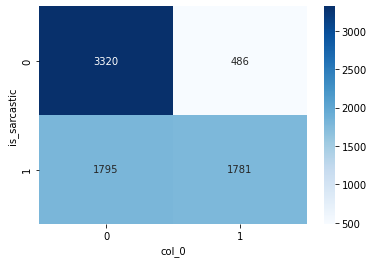

In [84]:
y_pred_test_exp_tfh = XGC_exp_tfh.predict(df_f_test_tf[s_cols])
confusion_mat(df_f_test_tf_y, y_pred_test_exp_tfh, 2)

In [85]:
y_pred_train_exp_tfh = XGC_exp_tfh.predict(df_f_train_tf[s_cols])
confusion_mat(df_f_train_tf_y, y_pred_train_exp_tfh, 5, display=0)

Accuracy :  0.711
F1 Score :  70.1829823195827


In [86]:
## Checking most important features along with their importances
importances = XGC_exp_tfh.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = []
ind = 1
for i in indices[:20]:
    f_name = df_f_train_tf[s_cols].iloc[:,i].name
    top_features.append(f_name)
    print(str(ind) + ". " + str(f_name) + " (" + str(importances[i]) + ")")
    ind += 1

1. man (0.028002622)
2. trump (0.013121366)
3. nation (0.012236805)
4. report (0.011506204)
5. introduces (0.011096721)
6. area (0.011083957)
7. shit (0.008823518)
8. local (0.008707959)
9. study (0.007611338)
10. romney (0.007595917)
11. excited (0.0075881467)
12. self (0.007184979)
13. archive (0.007130342)
14. bush (0.0069357534)
15. queer (0.006857322)
16. unveils (0.0068039)
17. headline_length (0.0067557525)
18. fuck (0.0067112637)
19. god (0.0066565685)
20. huffpost (0.0066498346)


Average precision-recall score on test: 0.63
Average precision-recall score on train: 0.67


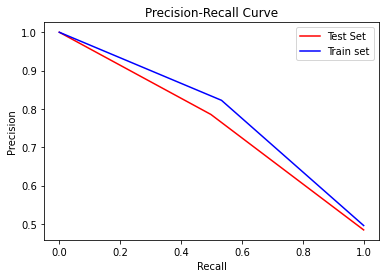

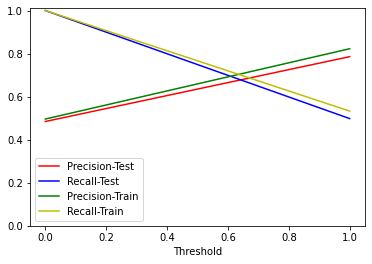

In [87]:
## Plotting Precision-Recall curves
precision, recall, thresholds = precision_recall_curve(df_f_test_tf_y, y_pred_test_exp_tfh)
precision_tr, recall_tr, thresholds_tr = precision_recall_curve(df_f_train_tf_y, y_pred_train_exp_tfh)
    

average_precision = average_precision_score(df_f_test_tf_y, y_pred_test_exp_tfh)
print('Average precision-recall score on test: {0:0.2f}'.format(average_precision))
average_precision_tr = average_precision_score(df_f_train_tf_y, y_pred_train_exp_tfh)
print('Average precision-recall score on train: {0:0.2f}'.format(average_precision_tr))
plt.plot(recall, precision, 'r')
plt.plot(recall_tr, precision_tr, 'b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(('Test Set', 'Train set'))
plt.show()

plt.plot(thresholds, precision[:-1], 'r')
plt.xlabel('Threshold')
plt.ylim([0,1.01])

plt.plot(thresholds, recall[:-1], 'b')
plt.xlabel('Threshold')
plt.ylim([0,1.01])
plt.legend(('Precision-Test', 'Recall-Test'))

plt.plot(thresholds_tr, precision_tr[:-1], 'g')
plt.xlabel('Threshold')
plt.ylim([0,1.01])

plt.plot(thresholds_tr, recall_tr[:-1], 'y')
plt.xlabel('Threshold')
plt.ylim([0,1.01])
plt.legend(('Precision-Test', 'Recall-Test', 'Precision-Train', 'Recall-Train'))
plt.show()

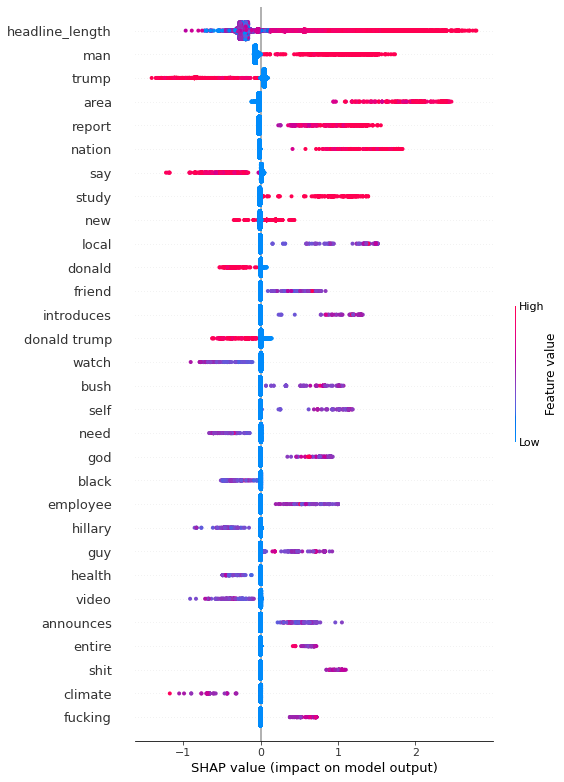

In [88]:
## Plotting SHAP tree explainer plot
explainer = shap.TreeExplainer(XGC_exp_tfh)
shap.summary_plot(explainer.shap_values(df_f_train_tf[s_cols]), df_f_train_tf[s_cols], max_display=30, class_names=XGC_exp_tfh.classes_)

### Comparing models

In [89]:
f1_bow_train = max(0, 100*f1_score(df_f_train_bow_y, y_pred_train_exp_bow, average = "weighted"))
f1_bow_test = max(0, 100*f1_score(df_f_test_bow_y, y_pred_test_exp_bow, average = "weighted"))
f1_tf_train = max(0, 100*f1_score(df_f_train_tf_y, y_pred_train_exp_tf, average = "weighted"))
f1_tf_test = max(0, 100*f1_score(df_f_test_tf_y, y_pred_test_exp_tf, average = "weighted"))
f1_tfh_train = max(0, 100*f1_score(df_f_train_tf_y, y_pred_train_exp_tfh, average = "weighted"))
f1_tfh_test = max(0, 100*f1_score(df_f_test_tf_y, y_pred_test_exp_tfh, average = "weighted"))

models_compare = pd.DataFrame({"Model Description": ["XGBoost with BoW", "XGBoost with TF-IDF", "XGBoost with TF-IDF (hypertuned)"],
                               "F1 score (Training)": [f1_bow_train, f1_tf_train, f1_tfh_train],
                               "F1 score (Testing)": [f1_bow_test, f1_tf_test, f1_tfh_test],})
models_compare

,Model Description,F1 score (Training),F1 score (Testing)
0,XGBoost with BoW,67.425654,66.417745
1,XGBoost with TF-IDF,67.557433,66.203267
2,XGBoost with TF-IDF (hypertuned),70.182982,67.906306


### Saving best model
Clearly, XGBoost with TF-IDF and hypertuning performed best across all models with ~3% higher F1 score in test set

In [90]:
pickle.dump(XGC_exp_tfh, open(model_path + "model_tfidf.pickle", 'wb'))

## Section 6: Conclusions

### Takeaways
1. Featured engineered variable - "headline_length" comes under top 20 most important features

2. NLP played a major role in this classification task. Some of the NLP tricks to clean the features used were – Removing punctuations, numbers, special characters, stop words, and lemmatization (reducing word to its root form)

3. Different approaches were tried to transform the text to vectorization - BagofWords and Tf-Idf

4. XGBoost was used as its known to perform well on tabular datasets (with considerable rows and feature counts)

5. GridSearchCV was applied to pick out the best parameters - Hyper-tuning helped in improving F1 Score by ~3%

6. Upon model comparison, XGBoost with TF-IDF and hyper-tuning performed the best


### Next-Steps

1. Text variables can be further cleaned by removing unimportant words. Max_features in both BoW and TF-IDF can be increased

2. Hyper tuning – Higher number of iterations can be tried

3. Pipeline – Due to many moving parts and preprocessing, it would be cleaner to create a pipeline to transform the data in one go